In [ ]:
!pip install scipy

In [18]:
import os
import pdb
import pickle
import argparse

import warnings
warnings.filterwarnings("ignore")

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Numpy & Scipy imports
import numpy as np
import scipy
import scipy.misc

# Local imports
import utils
from data_loader import get_emoji_loader
from models import CycleGenerator, DCDiscriminator

In [19]:
import os
import math
import random
import itertools

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

from IPython import display

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
import os

import torch
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

In [21]:
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F

In [22]:
SEED = 11

# Set the random seed manually for reproducibility.
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [23]:
image_size = 64
batchSize = 64
workers = 2

In [24]:
transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])

In [25]:
train_path = os.path.join('./emojis', "Apple")

In [26]:
train_dataset = datasets.ImageFolder(train_path, transform)

In [27]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 2270
    Root location: ./emojis/Apple

In [28]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=workers)

In [29]:
dataloader

In [30]:
nz = 100
ngf = 64
ndf = 64
nepochs = 100
lr = 0.0002
beta1 = 0.5

In [31]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)


def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, init_zero_weights=False):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    if init_zero_weights:
        conv_layer.weight.data = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.001
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

class ResnetBlock(nn.Module):
    def __init__(self, conv_dim):
        super(ResnetBlock, self).__init__()
        self.conv_layer = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = x + self.conv_layer(x)
        return out

In [32]:
nc = 3

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output.view(-1, 1)

In [33]:
class CycleGenerator(nn.Module):
    """Defines the architecture of the generator network.
       Note: Both generators G_XtoY and G_YtoX have the same architecture in this assignment.
    """
    def __init__(self, conv_dim=64, init_zero_weights=False):
        super(CycleGenerator, self).__init__()

        ###########################################
        ##   FILL THIS IN: CREATE ARCHITECTURE   ##
        ###########################################

        # 1. Define the encoder part of the generator (that extracts features from the input image)
        # self.conv1 = conv(...)
        # self.conv2 = conv(...)
        self.conv1 = conv(3, conv_dim, 4, init_zero_weights=init_zero_weights)
        self.conv2 = conv(conv_dim, 2*conv_dim, 4)

        # 2. Define the transformation part of the generator
        # self.resnet_block = ...
        self.resnet_block = ResnetBlock(2*conv_dim)

        # 3. Define the decoder part of the generator (that builds up the output image from features)
        # self.deconv1 = deconv(...)
        # self.deconv2 = deconv(...)
        self.deconv1 = deconv(2*conv_dim, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Generates an image conditioned on an input image.
            Input
            -----
                x: BS x 3 x 32 x 32
            Output
            ------
                out: BS x 3 x 32 x 32
        """

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))

        out = F.relu(self.resnet_block(out))

        out = F.relu(self.deconv1(out))
        out = F.tanh(self.deconv2(out))

        return out


class DCDiscriminator(nn.Module):
    """Defines the architecture of the discriminator network.
       Note: Both discriminators D_X and D_Y have the same architecture in this assignment.
    """
    def __init__(self, conv_dim=64):
        super(DCDiscriminator, self).__init__()

        ###########################################
        ##   FILL THIS IN: CREATE ARCHITECTURE   ##
        ###########################################

        # self.conv1 = conv(...)
        # self.conv2 = conv(...)
        # self.conv3 = conv(...)
        # self.conv4 = conv(...)
        self.conv1 = conv(3, conv_dim, 4);
        self.conv2 = conv(conv_dim, 2*conv_dim, 4)
        self.conv3 = conv(2*conv_dim, 4*conv_dim, 4)
        self.conv4 = conv(4*conv_dim, 1, 4,padding=1, batch_norm=False)


    def forward(self, x):

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.conv4(out).squeeze()
        out = F.sigmoid(out)
        return out

In [34]:
G = CycleGenerator()
G.apply(weights_init)
print(G)

D = DCDiscriminator()
D.apply(weights_init)
print(D)

CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resnet_block): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), 

In [35]:
criterion = nn.BCELoss()

noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)

D.cuda()
G.cuda()
criterion.cuda()
noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

fixed_noise = Variable(fixed_noise)

# setup optimizers
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

ValueError: Target and input must have the same number of elements. target nelement (64) != input nelement (1024)

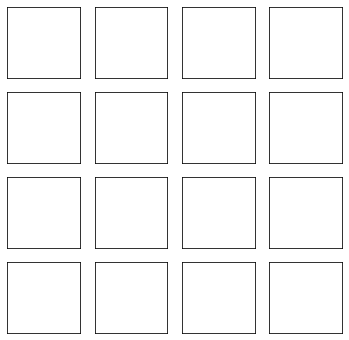

In [37]:
# create figure for plotting
num_test_samples = 16
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

def display_samples(fake_images):
    for k in range(num_test_samples):
        i = k//4
        j = k%4
        
        img = fake_images[k].data.cpu() / 2 + 0.5
        npimg = img.numpy()
        
        ax[i,j].cla()
        ax[i,j].imshow(np.transpose(npimg, (1, 2, 0)), cmap='Greys')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())


display_every = 100

for epoch in range(nepochs):
    
    i = 0
    
    for data in dataloader:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        D.zero_grad()
        real_images, _ = data
        batch_size = real_images.size(0)
        real_images = Variable(real_images.cuda())
        ones_label = Variable(torch.ones(batch_size).float().cuda())

        output = D(real_images)
        D_real_loss = criterion(output, ones_label)
        D_real_loss.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = G(noisev)
        zeros_label = Variable(torch.zeros(batch_size).float().cuda())
        output = D(fake.detach())
        D_fake_loss = criterion(output, zeros_label)
        D_fake_loss.backward()
        D_G_z1 = output.data.mean()
        D_loss = D_real_loss + D_fake_loss
        D_optimizer.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        ones_label = Variable(torch.ones(batch_size).float().cuda())
        D_out = D(fake)
        G_loss = criterion(D_out, ones_label)
        G_loss.backward()
        D_G_z2 = output.data.mean()
        G_optimizer.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, nepochs, i, len(dataloader),
                 D_loss.data, G_loss.data, D_x, D_G_z1, D_G_z2))
        
        
        if i % display_every == 0:
            # DISPLAY GRID OF SAMPLES
            test_images = G(fixed_noise)
            display_samples(test_images)
        
        i += 1